In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from helpers.cm26 import DatasetCM26
from helpers.selectors import select_NA, select_Pacific, select_Cem, select_globe, compare, plot
from helpers.operators import Coarsen, Filtering, Subsampling, CoarsenKochkov, CoarsenWeighted

import hvplot.xarray
import hvplot
import cmocean

%load_ext autoreload
%autoreload 3

In [3]:
%time ds = DatasetCM26()

CPU times: user 1.58 s, sys: 453 ms, total: 2.03 s
Wall time: 1.69 s


# Check that 3D and 2D data are the same up to time averaging

In [44]:
ocean = xr.open_dataset("gs://cmip6/GFDL_CM2_6/control/ocean_3d", engine='zarr', chunks={}, use_cftime=True).rename({'xu_ocean': 'xq', 'yu_ocean': 'yq'})

In [45]:
surface = xr.open_dataset("gs://cmip6/GFDL_CM2_6/control/surface", engine='zarr', chunks={}, use_cftime=True).rename({'xu_ocean': 'xq', 'yu_ocean': 'yq'})

In [46]:
uu = ocean.u[-1].isel(st_ocean=0)
uusurf = surface.usurf.sel(time=uu.time)

vv = ocean.v[-1].isel(st_ocean=0)
vvsurf = surface.vsurf.sel(time=vv.time)

Correlation: 0.9680201987469448
Relative Error: 0.2628937363624573
R2 =  0.9338989108800888
R2 max =  0.9378526844084263
Optinal scaling: 1.0694376230239868
Nans [test/control]: [127608, 127608]


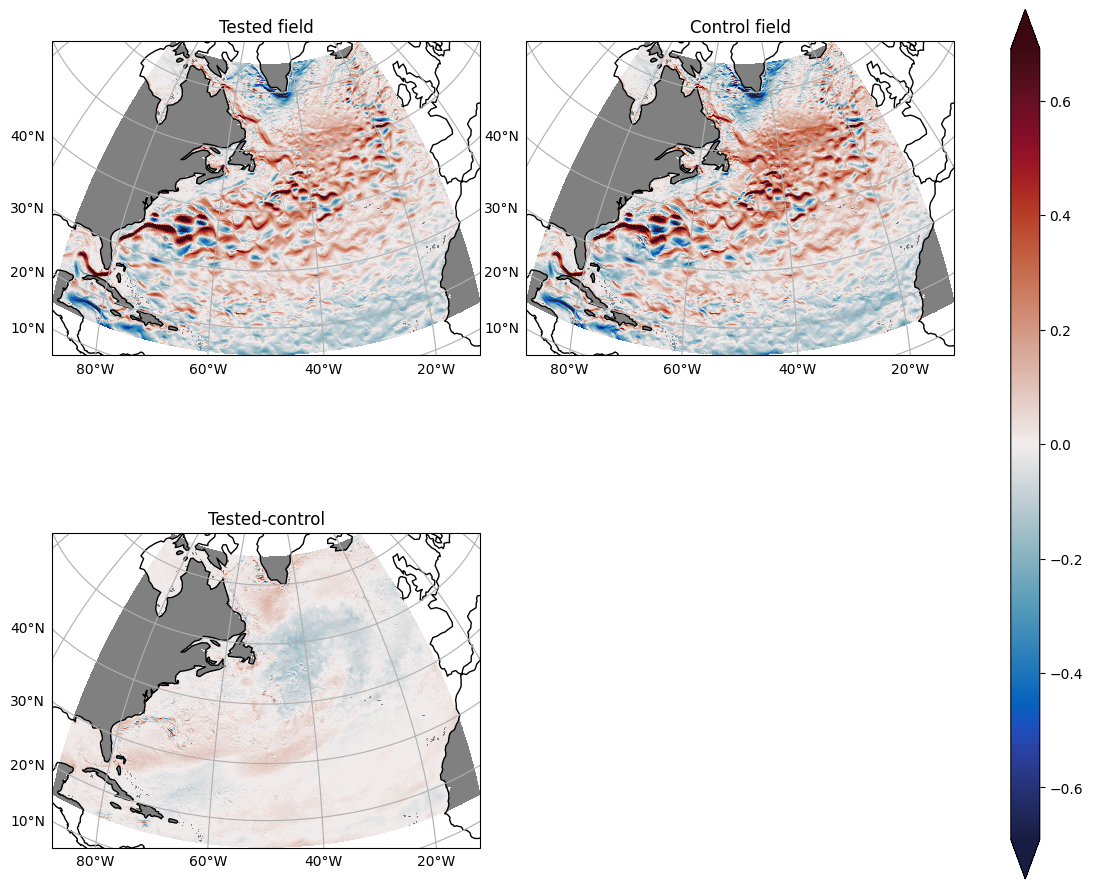

In [47]:
compare(uu, uusurf)

Correlation: 0.9605280731530997
Relative Error: 0.27888405323028564
R2 =  0.9219893664121628
R2 max =  0.922568716108799
Optinal scaling: 1.025705337524414
Nans [test/control]: [3648154, 3648154]


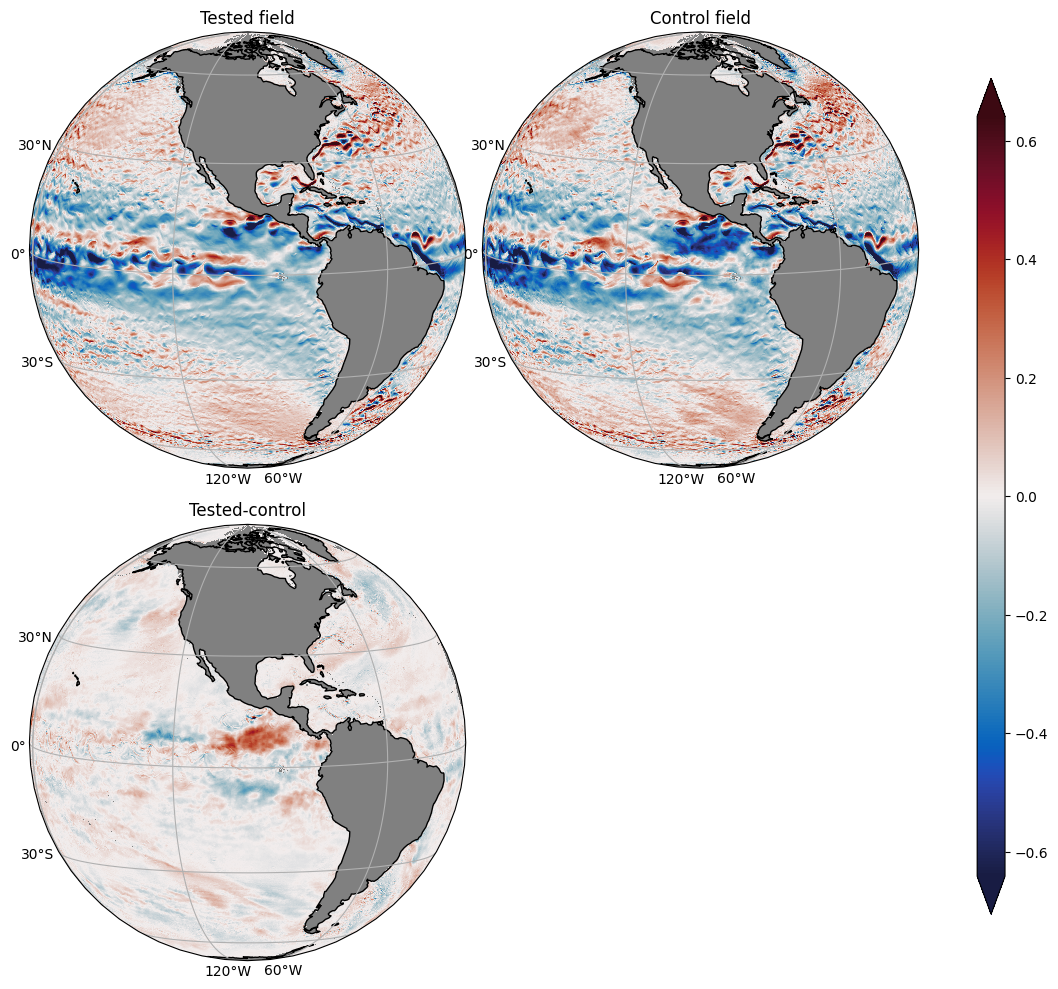

In [48]:
compare(uu, uusurf, selector=select_globe)

Correlation: 0.9573763288387133
Relative Error: 0.29094988107681274
R2 =  0.9143037647008896
R2 max =  0.9166042879223824
Optinal scaling: 1.0527403354644775
Nans [test/control]: [127608, 127608]


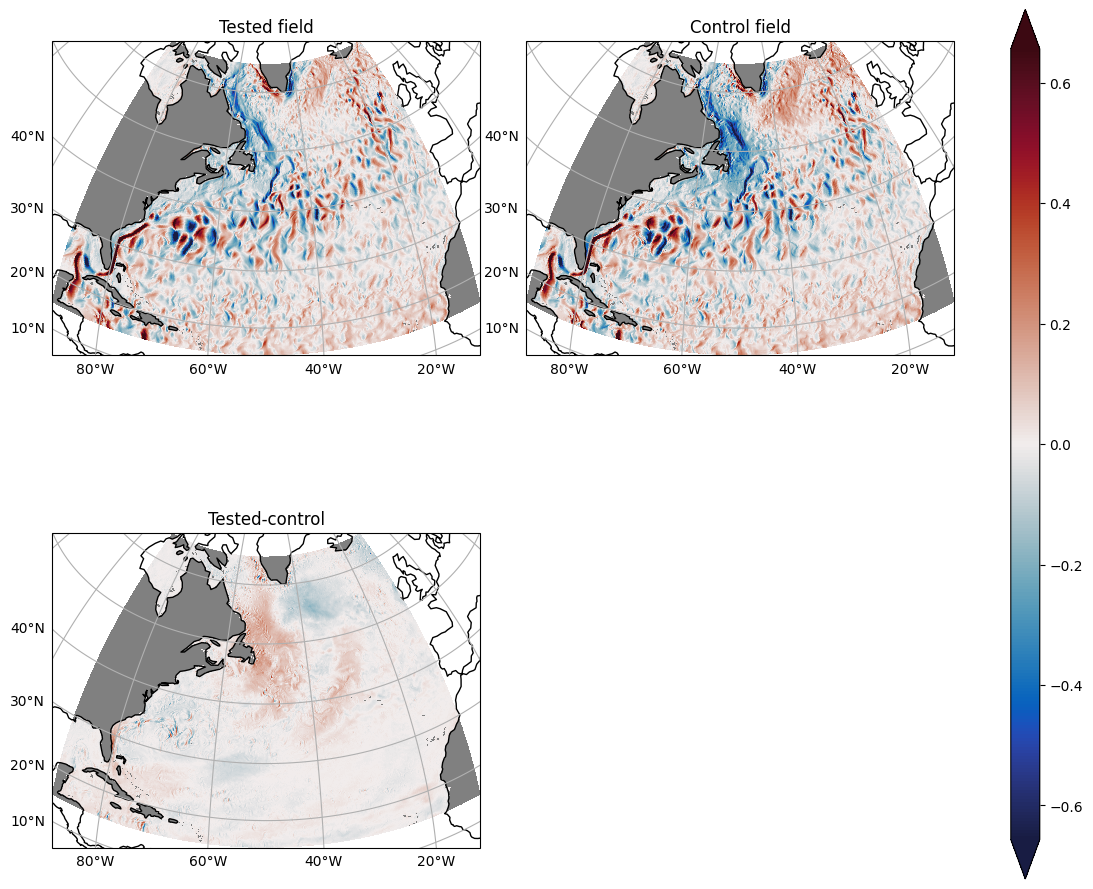

In [49]:
compare(vv, vvsurf)

Correlation: 0.9449209571661423
Relative Error: 0.33394894003868103
R2 =  0.8922330588102341
R2 max =  0.8928840979933739
Optinal scaling: 1.027752161026001
Nans [test/control]: [3648154, 3648154]


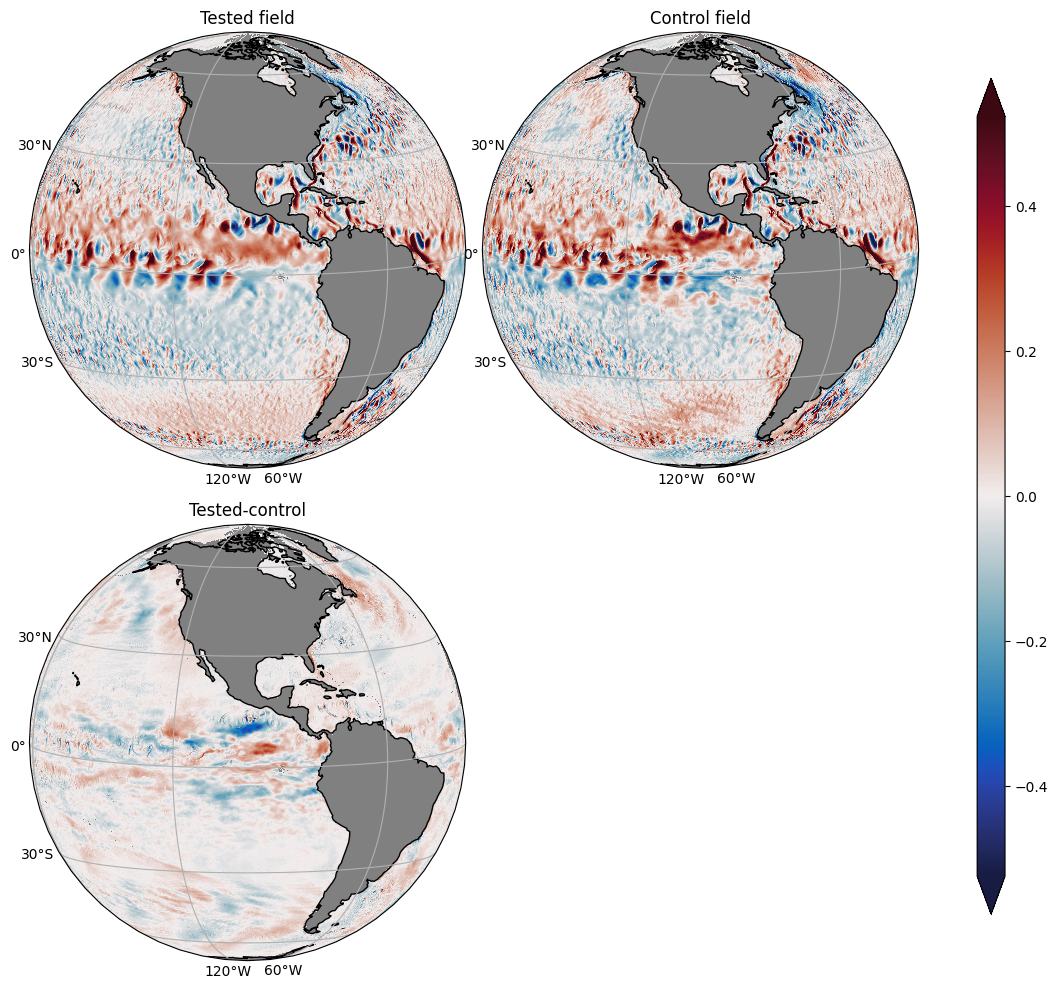

In [50]:
compare(vv, vvsurf, selector=select_globe)

# Extending dataset with 3D data

In [2]:
%time surface = DatasetCM26(source='cmip6')

CPU times: user 2.63 s, sys: 650 ms, total: 3.28 s
Wall time: 13.9 s


In [3]:
%time ocean = DatasetCM26(source='cmip6-3d')

CPU times: user 25.3 s, sys: 8.71 s, total: 34 s
Wall time: 19.8 s


In [4]:
%time ocean.param.wet_u.compute();

CPU times: user 1.23 ms, sys: 100 µs, total: 1.33 ms
Wall time: 1.13 ms


Correlation: 0.9692619025085955
Relative Error: 0.26008185744285583
R2 =  0.9360706806182861
R2 max =  0.9400775954127312
Optinal scaling: 1.069846272468567
Nans [test/control]: [0, 0]


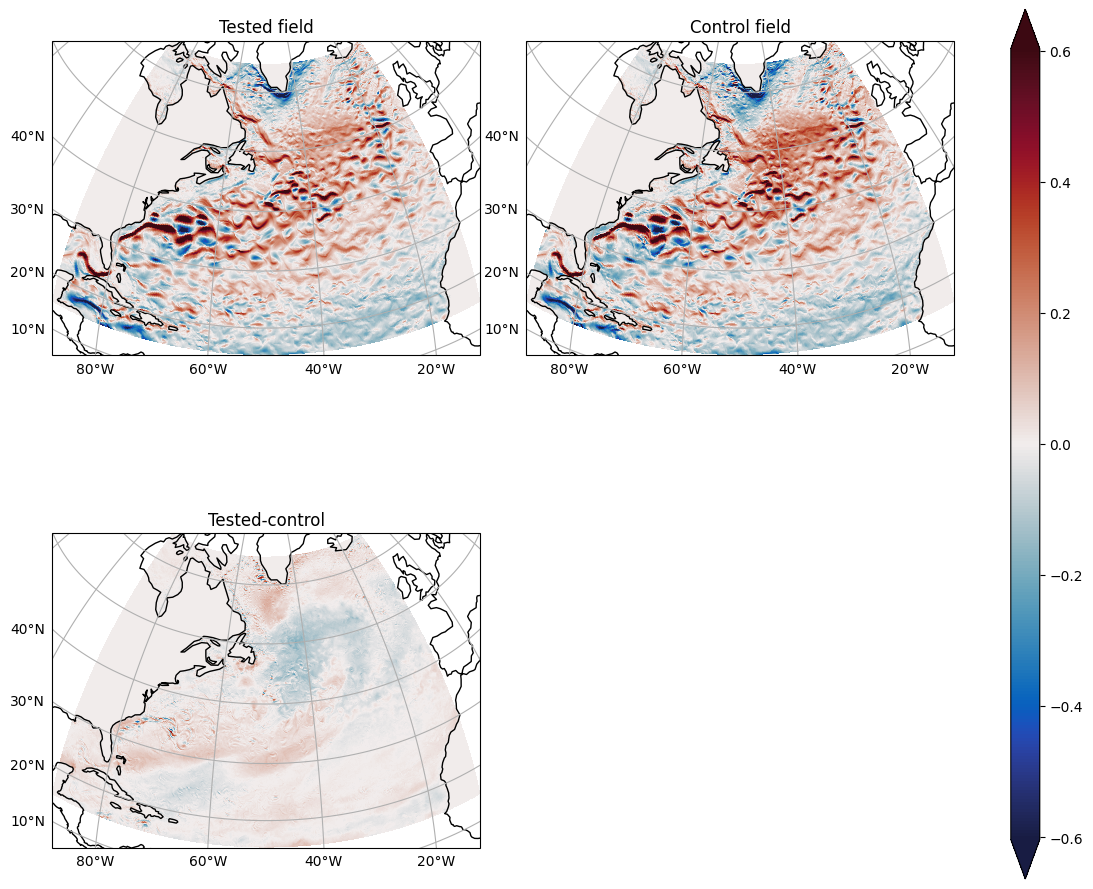

In [5]:
compare(ocean.data.u.isel(zl=0), surface.data.u[-4])

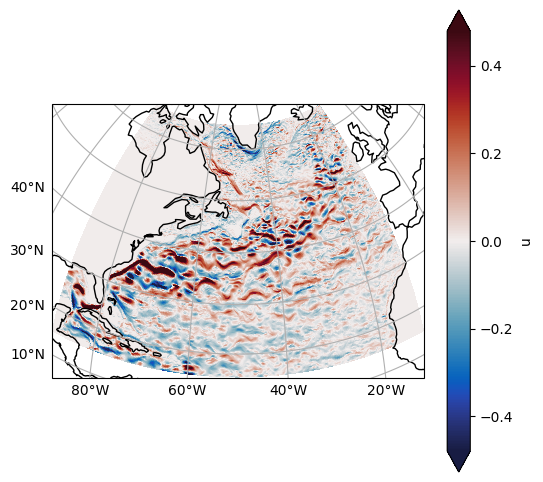

In [6]:
plot(ocean.split().data.u)

In [7]:
%time ocean_coarsen = ocean.coarsen()

CPU times: user 16.1 s, sys: 1.32 s, total: 17.5 s
Wall time: 17.5 s


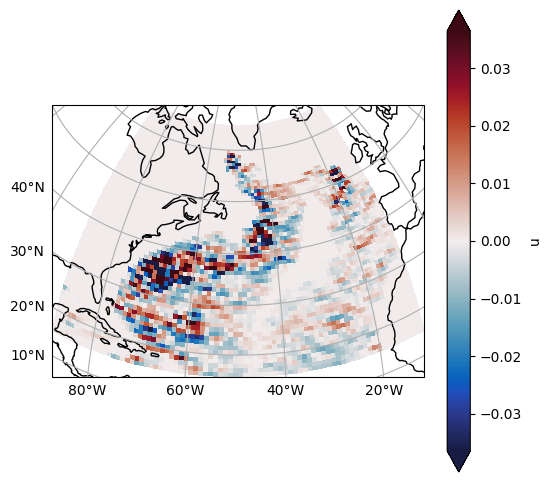

In [8]:
plot(ocean_coarsen.data.u.isel(zl=40))

In [26]:
%time ocean_coarsen.data.u.isel(time=slice(0,1),zl=slice(0,1)).compute();
%time ocean_coarsen.data.u.isel(time=slice(0,14),zl=slice(0,1)).compute();
%time ocean_coarsen.data.u.isel(time=slice(0,1),zl=slice(0,14)).compute();

CPU times: user 1.3 s, sys: 300 ms, total: 1.6 s
Wall time: 1.82 s
CPU times: user 5.01 s, sys: 2.18 s, total: 7.19 s
Wall time: 2.62 s
CPU times: user 6.98 s, sys: 3.66 s, total: 10.6 s
Wall time: 2.75 s


In [28]:
%time SGS = ocean.compute_subgrid_forcing()

CPU times: user 1min 32s, sys: 5.46 s, total: 1min 38s
Wall time: 1min 37s


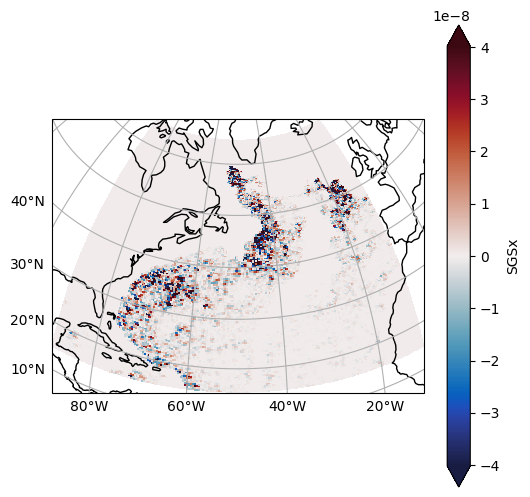

In [36]:
plot(SGS.data.SGSx.isel(zl=40))

In [43]:
%time SGS.data.SGSx.isel(zl=1,time=-1).compute();
%time SGS.data.SGSx.isel(zl=slice(0,14),time=-1).compute();
%time SGS.data.SGSx.isel(zl=0,time=slice(0,14)).compute();

CPU times: user 10.3 s, sys: 3.32 s, total: 13.6 s
Wall time: 9.01 s
CPU times: user 39.7 s, sys: 18.4 s, total: 58.2 s
Wall time: 13.1 s
CPU times: user 36.3 s, sys: 15.5 s, total: 51.7 s
Wall time: 12.2 s


In [44]:
%time SGS.data.SGSx.isel(zl=slice(0,50,5),time=0).compute();

CPU times: user 30.8 s, sys: 13.6 s, total: 44.4 s
Wall time: 11.4 s


In [46]:
%time SGS_surface = surface.compute_subgrid_forcing()

CPU times: user 13.9 s, sys: 678 ms, total: 14.6 s
Wall time: 13.8 s


In [49]:
%time SGS_surface.data.SGSx.isel(time=slice(0,1)).compute();
%time SGS_surface.data.SGSx.isel(time=slice(0,14)).compute();

CPU times: user 2.95 s, sys: 1.32 s, total: 4.27 s
Wall time: 2.58 s
CPU times: user 28.8 s, sys: 13.4 s, total: 42.2 s
Wall time: 7.02 s
